## Quantitative Analysis: Bitcoin Price Prediction for Hourly-frequency Trading
5/28/2023
<br>Lidong (Aaron) Yang
<br>Jiadi Zhang

Disclaimer: I have not tried running the entire notebook in one click, purely because of how long training the models take. For now, just look at the results and methodologies. Besides, I am sure you can further optimize the neural network models, but because of the lack of time, I first will settle with the current result.

Other prediction methodologies worth exploring: use binary classification to predict the rise or fall of the hourly price. Weight each row by the degree of price change. I am pessimistic about this method because it is too complicated. 

# Notbook layout:

1. Data-preprocessing
2. Feature engineering
3. Some investigative studies
4. Modeling: each model predicts either the price or the price change of the next hour of bitcoin. Each model has at least two versions:
    1) Linear models:
    <br> lasso1: a lasso regression that predicts price with all available features
    <br> lasso2: a lsso regression that predicts price with only features that describe the previous prices of bitcoin.
    <br> ridge1: a ridge regression that predicts price with all available features 
    <br> ridge2: a ridge regression that predicts price with only features that describe the previous prices of bitcoin.
    <br> ridge3: a ridge regression that predcits price change of bitcoin with only features that describe the previous prices of bitcoin.
    2) Tree_based models:
    <br> random forest1: a random forest regression that predicts price with all available features 
    <br> random forest2: a random forest regression that predicts price with only features that describe the previous prices of bitcoin.
    <br> XGBoost1: a XGB regression that predicts price of bitcoin with all available features 
    <br> XGBoost2: a XGB regression that predicts price with features that describe the previous prices of bitcoin.
    3) Neural Network
    <br> Multi-layer perceptron1: a MLP neural net that predicts the price of bitcoin with all available features
    <br> Multi-layer perceptron2: a MLP neural net that predicts the price change of bitcoin with all available features
    <br> LSTM1: a LSTM neural net that predicts the price of bitcoin with all available features
    <br> LSTM2: a LSTM neural net that has its exclusive feature engineering. This LSTM model accepts only time-series input.
5. Trading simulation on validation set.
6. Examining test set performances.
7. Trading simulation on the test sets.

### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import GridSearchCV  
from sklearn.pipeline import make_pipeline

In [2]:
df_price = pd.read_csv('data/bitcoin-price-usd.csv')

In [3]:
# check for missing data
if df_price.isnull().values.any():
    print('Missing data detected')
else:
    print('No missing data detected.')

No missing data detected.


In [4]:
# check if the timestamp is continuous
df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])

df_price['time_diff'] = df_price['timestamp'].diff()
gaps = df_price[df_price['time_diff'] > pd.Timedelta('1 hour')]

if gaps.empty:
    print('No missing hourly data.')
else:
    print('Missing hourly data detected:')
    print(gaps)

No missing hourly data.


In [5]:
# Now I want to see daily open, close, high, and low price
# convert timestamp to datetime
df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])
df_price['date'] = df_price['timestamp'].dt.date

# resample to daily data
df_price_daily = df_price.groupby('date').agg({
    'value': ['first', 'last', 'max', 'min']
})

df_price_daily.columns = ['_'.join(t) for t in df_price_daily.columns]

df_price_daily.rename(columns={
    'value_first': 'open',
    'value_last': 'close',
    'value_max': 'high',
    'value_min': 'low',
}, inplace=True)

# To prevent data leaking, we only observe the previous day's price when we predict BTC
# So, add previous day's open, close, high, and low prices
df_price_daily['prev_open'] = df_price_daily['open'].shift()
df_price_daily['prev_close'] = df_price_daily['close'].shift()
df_price_daily['prev_high'] = df_price_daily['high'].shift()
df_price_daily['prev_low'] = df_price_daily['low'].shift()


# merge daily data back to original dataset
df_price = df_price.merge(df_price_daily, how='left', left_on='date', right_index=True)


In [6]:
# load the additional csv files

df_number_of_addresses = pd.read_csv('data/bitcoin-number-of-addresses-with-balance-100.csv')
df_transfer_volume = pd.read_csv('data/bitcoin-total-transfer-volume-entity-adjusted-btc.csv')


df_number_of_addresses['timestamp'] = pd.to_datetime(df_number_of_addresses['timestamp'])
df_transfer_volume['timestamp'] = pd.to_datetime(df_transfer_volume['timestamp'])


df_number_of_addresses.rename(columns= {'value': 'number_of_addresse',}, inplace=True)
df_transfer_volume.rename(columns= {'value': 'total-transfer-volume',}, inplace=True)

# Same apply here, we only observe the previous hour/day's data when we predict BTC
# So, add previous hour/day's related data
df_number_of_addresses['prev_number_of_addresse'] = df_number_of_addresses['number_of_addresse'].shift()
df_transfer_volume['prev_total-transfer-volume'] = df_transfer_volume['total-transfer-volume'].shift()

# merge these dataframes with the original dataframe
df_price = df_price.merge(df_number_of_addresses, how='left', on='timestamp')
df_price = df_price.merge(df_transfer_volume, how='left', on='timestamp')

In [7]:
df_net_position = pd.read_csv('data/bitcoin-long-term-holder-net-position-change.csv')
df_net_position['timestamp'] = pd.to_datetime(df_net_position['timestamp'])
df_net_position['date'] = df_net_position['timestamp'].dt.date
df_net_position.drop('timestamp', axis=1, inplace=True)
df_net_position.rename(columns= {'value': 'net_position_change',}, inplace=True)
df_net_position['prev_net_position_change'] = df_net_position['net_position_change'].shift()
df_price = df_price.merge(df_net_position, how='left', on='date')

In [8]:
df_supply = pd.read_csv('data/bitcoin-relative-address-supply-distribution.csv')
df_supply['timestamp'] = pd.to_datetime(df_supply['timestamp'])
df_supply['date'] = df_supply['timestamp'].dt.date
df_supply.drop('timestamp', axis=1, inplace=True)

for col in df_supply.columns:
    if col != 'date': 
        df_supply['prev_' + col] = df_supply[col].shift()
df_supply = df_supply.drop(columns=['0001_001', '001_01', '01_1', '100_1k', '10_100', '10k_100k', '1_10', '1k_10k', 'above_100k', 'less_0001'])
df_price = df_price.merge(df_supply, how='left', on='date')

In [9]:
df_price['total-transfer-scale'] = df_price['total-transfer-volume'] * df_price['value']

df_price['prev_total-transfer-scale'] = df_price['total-transfer-scale'].shift()


In [10]:
df_price['prev_value'] = df_price['value'].shift()

In [11]:
df_price_date = df_price.groupby('date').agg(
    open=('open', 'first'),
    close=('close', 'last'),
    high=('high', 'max'),
    low=('low', 'min')
)

# Create a candlestick plot
candlestick = go.Candlestick(
x = df_price_date.index,
open = df_price_date['open'],
high = df_price_date['high'],
low = df_price_date['low'],
close = df_price_date['close'])

fig = go.Figure(data=[candlestick])

fig.show()

In [12]:
df_price = df_price.drop(['time_diff','net_position_change','open', 'close', 'high', 'low','number_of_addresse','total-transfer-volume','total-transfer-scale'], axis=1)

A lot of fluctuation in recent years.

## Feature Engineering
This part is refered to https://medium.com/@rohansawant7978/forecasting-of-bitcoin-price-using-machine-learning-deep-learning-techniques-93bf662f46ab
<br>I consider using the following features:
### Simple Moving Average
* A simple moving average (SMA) calculates the average of a selected range of feature values for a number of periods in that range.

* It determins if an asset price will continue or if it will reverse a bull or bear trend.

### Exponential Moving Average
* The EMA is a moving average that places a greater weight and significance on the most recent data points. They work similar to WMA but formula is different.
![Image](https://www.thebalance.com/thmb/bUl41pugmmQnuoLXScHzSAAla3c=/1648x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/EMA-a566789cf300425c80352fb70a6c0666.jpg)
* The EMA adapts more quickly to price changes than the SMA does. For example, when a price reverses direction, the EMA will reverse direction more quickly than the SMA will, because the EMA formula gives more weight to recent prices and less weight to prices from the past.

### Bollinger Bands
* Bollinger Bands are envelopes (Upper and Lower range levels) plotted at a standard deviation level above and below a simple moving average of the price. Because the distance of the bands is based on standard deviation, they adjust to volatility swings in the underlying price.


```
Upper band: n-day SMA + (n-day standard deviation x2)
Lower band: n-day SMA – (n-day standard deviation x2)

```

* Bollinger bands help determine whether values are high or low on a relative basis. They are used in pairs, both upper and lower bands and in conjunction with a moving average. Further, the pair of bands is not intended to be used on its own. Use the pair to confirm signals given with other indicators.

## Moving Average Convergence Divergence
The MACD represents a trend following indicator that highlights whether the short-term price momentum is moving in the same direction as the long-term price momentum, and in cases where it's not, then it's used to determine if a trend change is near. The MACD consists of four components.

MACD line- shows the variation between the slow moving average and the fast-moving average

Signal line-for signaling fluctuations in price momentum

Histogram- indicates the difference between the signal line and the MACD line.

## Relative Strength Index

> RSI = 100 – 100 / (1 + RS)

> RS = Average of X periods closes up / Average of X periods closes down

An asset is considered oversold or undervalued when the RSI drops below 30. On the other hand, it's deemed to be overbought if the RSI goes above 70.

## Rate of Change
* Measures the percentage change in price between the current feature value and the feature a certain number of periods ago.e.g., 7,30,90

*   A rising ROC above zero typically confirms an uptrend while a falling ROC below zero indicates a downtrend.



In [13]:
def feature_engineering(df,feature_name,smoothening_type,smoothening_range=[7,30,90],show_plot=False,show_original_Feature_in_plot=True):
    if smoothening_type == 'sma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.sma(df[feature_name],j) 

    elif smoothening_type == 'ema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.ema(df[feature_name],j)

    elif smoothening_type == 'bband_lower':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBL_{j}_2.0']

    elif smoothening_type == 'bband_upper':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBU_{j}_2.0']
    
    elif smoothening_type == 'rsi':
        for j in smoothening_range:
             df[f'{smoothening_type}{j} {feature_name}'] = ta.rsi(df[feature_name],j)

    elif smoothening_type == 'roc':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.roc(df[feature_name],j)
    
    elif smoothening_type == 'macd':
        macd_df = ta.macd(df[feature_name])
        df[f'{smoothening_type} hist {feature_name}'] = macd_df['MACDh_12_26_9']
        df[f'{smoothening_type} signal {feature_name}'] = macd_df['MACDs_12_26_9']
        df[f'{smoothening_type} {feature_name}'] = macd_df['MACD_12_26_9']
    
    if show_plot == True and show_original_Feature_in_plot==True :
        df[[feature_name]+[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Engineering-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

    elif show_plot == True and show_original_Feature_in_plot==False :
        df[[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Engineering-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

In [14]:
feature_list = [i for i in list(df_price_date.columns) if i not in ['date','value']]

In [15]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'sma',show_plot=False)

In [16]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'ema',show_plot=False)

In [17]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'bband_lower',show_plot=False)

In [18]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'bband_upper',show_plot=False)

In [19]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'macd',show_plot=False)

In [20]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'rsi',show_plot=False)

In [21]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'roc',show_plot=False)

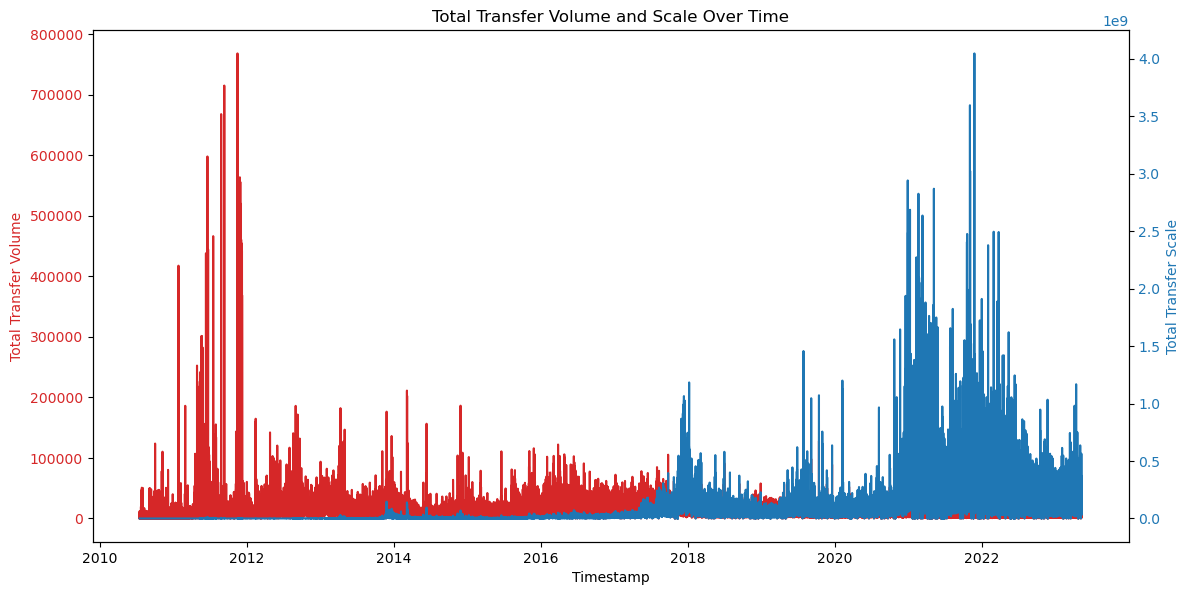

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total-transfer-volume and total-transfer-scale
color = 'tab:red'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Total Transfer Volume', color=color)
ax1.plot(df_price['timestamp'], df_price['prev_total-transfer-volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Transfer Scale', color=color)  
ax2.plot(df_price['timestamp'], df_price['prev_total-transfer-scale'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Total Transfer Volume and Scale Over Time')
plt.show()

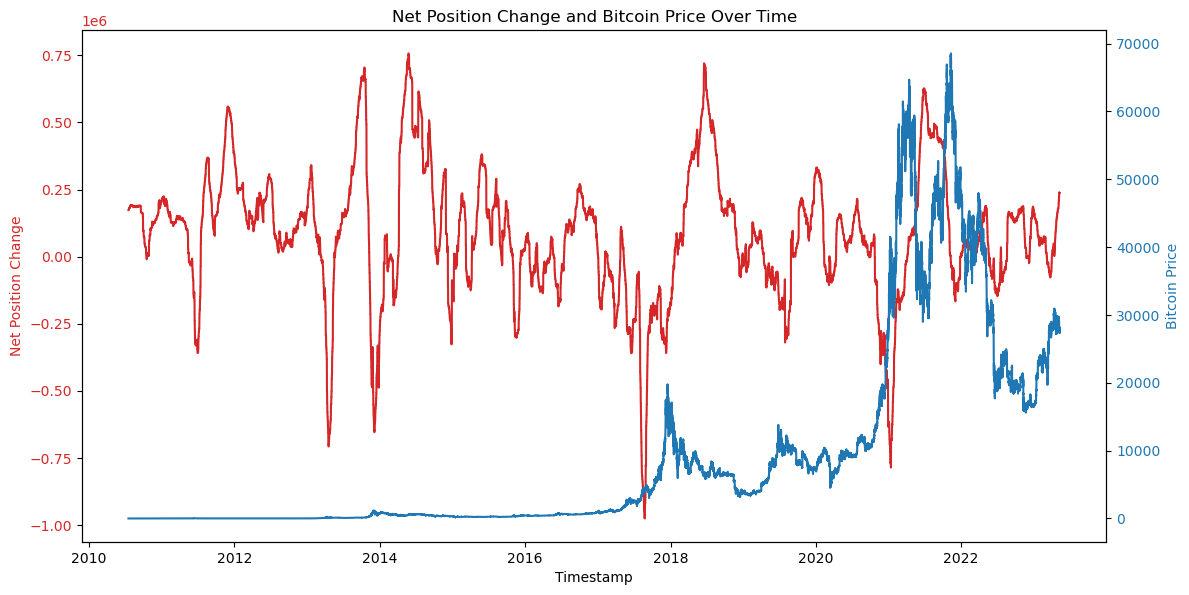

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot net_position_change
color = 'tab:red'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Net Position Change', color=color)
ax1.plot(df_price['timestamp'], df_price['prev_net_position_change'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Bitcoin Price', color=color)
ax2.plot(df_price['timestamp'], df_price['prev_value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Net Position Change and Bitcoin Price Over Time')
plt.show()


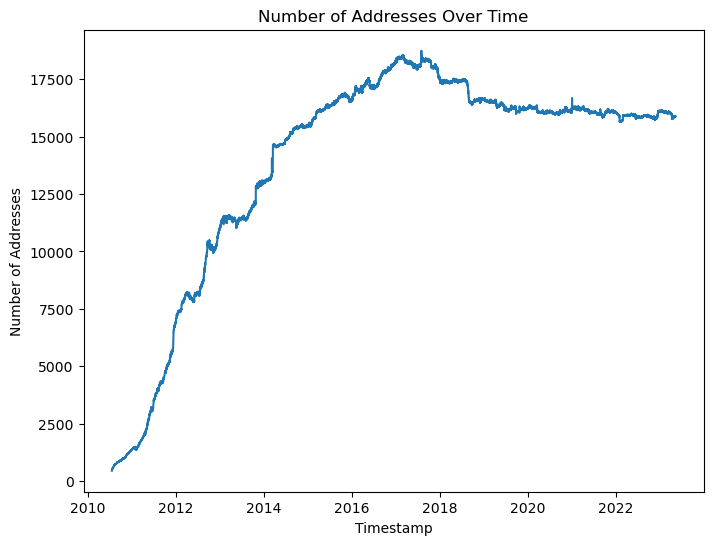

In [24]:
# Plot number_of_addresse
plt.figure(figsize=(8, 6))
plt.plot(df_price['timestamp'], df_price['prev_number_of_addresse'])
plt.title('Number of Addresses Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Addresses')
plt.show()


### Some interesting findings:
<br>1. In the early stage of Bitcoin issuance, the number of transactions was huge, but then decreased. This may be due to the low initial currency value, as can be seen from the 'Total Transfer Scale Over Time' graph on the right (Transfer Scale = Volume * Price).
<br>2. Net Position Change also seems to be a good signal. By comparing Net Position and bitcoin currency value changes, we can find that the two show a reverse trend, and the price response has a certain hysteresis, which is very simliar to the Herding Behavior and Anchoring Effect in traditional finance, and with the special properties of Bitcoin (mainly OTC), these effects may be exacerbated. In addition, the Loss Aversion and Disposition Effect is also obvious, and there have been many short-term panic sellings and buyings soon (the time interval is shorter than that of Long Postion).
<br>3. The transaction address peaked in 2018 and then stabilized in the region, which may be related to the limited supply of Bitcoin.

In [25]:
# Merge the dataframes
df_price['date'] = pd.to_datetime(df_price['date'])
#df_price_date = df_price_date.drop(['open', 'close', 'high', 'low'], axis=1)
df_price_date.index = pd.to_datetime(df_price_date.index)

df = pd.merge(df_price, df_price_date, left_on='date', right_index=True)


In [26]:
# Now it's time to play with the NAs
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']
missing_data_grouped = missing_data.groupby('Column').sum()
missing_data_grouped = missing_data_grouped.sort_values('Missing Count', ascending=False)
missing_data_grouped
# Seems a lot

Missing Count
Column                    
rsi90 open            2137
roc90 close           2137
rsi90 high            2137
rsi90 close           2137
rsi90 low             2137
...                    ...
high                     0
date                     0
close                    0
timestamp                0
value                    0

[110 rows x 1 columns]

In [27]:
df = df[df['date'] > '2010-10-17']

In [28]:
df = df.copy()

In [29]:
# backward fill the missing values
df = df.fillna(method='bfill')

In [30]:
# Get a DataFrame with True at places where there is a missing value
missing_value_mask = df.isna()

timestamps_with_missing_values = df['timestamp'][missing_value_mask.any(axis=1)]
timestamps_with_missing_values

112297   2023-05-10 00:00:00+00:00
112298   2023-05-10 01:00:00+00:00
112299   2023-05-10 02:00:00+00:00
112300   2023-05-10 03:00:00+00:00
112301   2023-05-10 04:00:00+00:00
112302   2023-05-10 05:00:00+00:00
112303   2023-05-10 06:00:00+00:00
112304   2023-05-10 07:00:00+00:00
112305   2023-05-10 08:00:00+00:00
112306   2023-05-10 09:00:00+00:00
112307   2023-05-10 10:00:00+00:00
112308   2023-05-10 11:00:00+00:00
112309   2023-05-10 12:00:00+00:00
112310   2023-05-10 13:00:00+00:00
112311   2023-05-10 14:00:00+00:00
112312   2023-05-10 15:00:00+00:00
112313   2023-05-10 16:00:00+00:00
112314   2023-05-10 17:00:00+00:00
112315   2023-05-10 18:00:00+00:00
112316   2023-05-10 19:00:00+00:00
112317   2023-05-10 20:00:00+00:00
112318   2023-05-10 21:00:00+00:00
112319   2023-05-10 22:00:00+00:00
112320   2023-05-10 23:00:00+00:00
112321   2023-05-11 00:00:00+00:00
112322   2023-05-11 01:00:00+00:00
112323   2023-05-11 02:00:00+00:00
112324   2023-05-11 03:00:00+00:00
112325   2023-05-11 

In [31]:
# only the lastest 2 days have missing values, drop 'em
df = df.dropna()

In [32]:
# Aagin, check on missing values
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']
missing_data_grouped = missing_data.groupby('Column').sum()
missing_data_grouped
missing_data_grouped = missing_data_grouped.sort_values('Missing Count', ascending=False)
missing_data_grouped

Missing Count
Column                                  
bband_lower30 close                    0
prev_total-transfer-scale              0
roc90 close                            0
roc7 open                              0
roc7 low                               0
...                                  ...
ema7 open                              0
ema7 low                               0
ema7 high                              0
ema7 close                             0
value                                  0

[110 rows x 1 columns]

Well, now it looks much better ;)

In [33]:
# Finalize the dataset for training
# drop all the columns that we cannot access at the time we predict
df_final = df.copy()
df_final

timestamp         value       date     prev_open   
2209   2010-10-18 00:00:00+00:00      0.102000 2010-10-18      0.101000  \
2210   2010-10-18 01:00:00+00:00      0.102000 2010-10-18      0.101000   
2211   2010-10-18 02:00:00+00:00      0.103000 2010-10-18      0.101000   
2212   2010-10-18 03:00:00+00:00      0.102000 2010-10-18      0.101000   
2213   2010-10-18 04:00:00+00:00      0.102000 2010-10-18      0.101000   
...                          ...           ...        ...           ...   
112292 2023-05-09 19:00:00+00:00  27654.374443 2023-05-09  28597.833708   
112293 2023-05-09 20:00:00+00:00  27642.341848 2023-05-09  28597.833708   
112294 2023-05-09 21:00:00+00:00  27640.286058 2023-05-09  28597.833708   
112295 2023-05-09 22:00:00+00:00  27577.716353 2023-05-09  28597.833708   
112296 2023-05-09 23:00:00+00:00  27652.946630 2023-05-09  28597.833708   

          prev_close     prev_high      prev_low  prev_number_of_addresse   
2209        0.102000      0.104500      0.100010                    967.0  \
2210        0.102000      0.104500      0.100010                    967.0   
2211        0.102000      0.104500      0.100010                    967.0   
2212        0.102000      0.104500      0.100010                    966.0   
2213        0.102000      0.104500      0.100010                    966.0   
...              ...           ...           ...                      ...   
112292  27716.367263  28597.833708  27384.168209                  15876.0   
112293  27716.367263  28597.833708  27384.168209                  15875.0   
112294  27716.367263  28597.833708  27384.168209                  15875.0   
112295  27716.367263  28597.833708  27384.168209                  15878.0   
112296  27716.367263  28597.833708  27384.168209                  15882.0   

        prev_total-transfer-volume  prev_net_position_change  ...  roc90 open   
2209                   1535.030000              13499.106409  ...   26.237624  \
2210                    254.530000              13499.106409  ...   26.237624   
2211                   1149.110000              13499.106409  ...   26.237624   
2212                    228.050000              13499.106409  ...   26.237624   
2213                  10073.510000              13499.106409  ...   26.237624   
...                            ...                       ...  ...         ...   
112292                 3283.273403             236875.504964  ...   18.273769   
112293                11195.802709             236875.504964  ...   18.273769   
112294                 5395.681867             236875.504964  ...   18.273769   
112295                 3495.142087             236875.504964  ...   18.273769   
112296                 3328.758492             236875.504964  ...   18.273769   

        roc7 close  roc30 close  roc90 close  roc7 high  roc30 high   
2209      7.789474    67.868852    37.020517   1.477833   68.852459  \
2210      7.789474    67.868852    37.020517   1.477833   68.852459   
2211      7.789474    67.868852    37.020517   1.477833   68.852459   
2212      7.789474    67.868852    37.020517   1.477833   68.852459   
2213      7.789474    67.868852    37.020517   1.477833   68.852459   
...            ...          ...          ...        ...         ...   
112292   -3.474621    -2.425759    20.513432  -3.487917   -2.355546   
112293   -3.474621    -2.425759    20.513432  -3.487917   -2.355546   
112294   -3.474621    -2.425759    20.513432  -3.487917   -2.355546   
112295   -3.474621    -2.425759    20.513432  -3.487917   -2.355546   
112296   -3.474621    -2.425759    20.513432  -3.487917   -2.355546   

        roc90 high  roc7 low  roc30 low  roc90 low  
2209     25.901479   9.89011  71.713125  34.661998  
2210     25.901479   9.89011  71.713125  34.661998  
2211     25.901479   9.89011  71.713125  34.661998  
2212     25.901479   9.89011  71.713125  34.661998  
2213     25.901479   9.89011  71.713125  34.661998  
...            ...       ...        ...        ...  


## Modeling
<br>We wil use MAE, RMSE and R2 to test the models' accuracies.
<br>We will use ridge, lasso, random forest, XGBoost, MLP, and LSTM.

In [34]:
def r_squared(y_true, y_hat):
    y_true = np.array(y_true).flatten()
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean)**2)
    ss_residual = np.sum((y_true - y_hat)**2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [35]:
def calculate_metrics(y, ypred):
    y = np.array(y).flatten()
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    r2 =  r_squared(ypred,y)
    first_string = 'The MAE is '+str(MAE) + '. '
    second_string = '\nThe RMSE is '+str(RMSE) + '. '
    third_string = '\nThe r_squared is '+str(r2) + '.'
    print(first_string, second_string, third_string)

In [36]:
def calculate_change_metrics(df, real_price, pred_price):
    i = 1
    lista = []
    lista2 = []
    while i < len(df):
        real_change = df[real_price][i] - df[real_price][i-1]
        lista.append(real_change)
        pred_change = df[pred_price][i] - df[real_price][i-1] 
        lista2.append(pred_change)
        i += 1
    change_df = pd.DataFrame({'real_change':lista, 'pred_change':lista2})
    return calculate_metrics(change_df['pred_change'],change_df['real_change'])

In [37]:
df_final = df_final.set_index('timestamp')
df_final

value       date     prev_open   
timestamp                                                          
2010-10-18 00:00:00+00:00      0.102000 2010-10-18      0.101000  \
2010-10-18 01:00:00+00:00      0.102000 2010-10-18      0.101000   
2010-10-18 02:00:00+00:00      0.103000 2010-10-18      0.101000   
2010-10-18 03:00:00+00:00      0.102000 2010-10-18      0.101000   
2010-10-18 04:00:00+00:00      0.102000 2010-10-18      0.101000   
...                                 ...        ...           ...   
2023-05-09 19:00:00+00:00  27654.374443 2023-05-09  28597.833708   
2023-05-09 20:00:00+00:00  27642.341848 2023-05-09  28597.833708   
2023-05-09 21:00:00+00:00  27640.286058 2023-05-09  28597.833708   
2023-05-09 22:00:00+00:00  27577.716353 2023-05-09  28597.833708   
2023-05-09 23:00:00+00:00  27652.946630 2023-05-09  28597.833708   

                             prev_close     prev_high      prev_low   
timestamp                                                             
2010-10-18 00:00:00+00:00      0.102000      0.104500      0.100010  \
2010-10-18 01:00:00+00:00      0.102000      0.104500      0.100010   
2010-10-18 02:00:00+00:00      0.102000      0.104500      0.100010   
2010-10-18 03:00:00+00:00      0.102000      0.104500      0.100010   
2010-10-18 04:00:00+00:00      0.102000      0.104500      0.100010   
...                                 ...           ...           ...   
2023-05-09 19:00:00+00:00  27716.367263  28597.833708  27384.168209   
2023-05-09 20:00:00+00:00  27716.367263  28597.833708  27384.168209   
2023-05-09 21:00:00+00:00  27716.367263  28597.833708  27384.168209   
2023-05-09 22:00:00+00:00  27716.367263  28597.833708  27384.168209   
2023-05-09 23:00:00+00:00  27716.367263  28597.833708  27384.168209   

                           prev_number_of_addresse   
timestamp                                            
2010-10-18 00:00:00+00:00                    967.0  \
2010-10-18 01:00:00+00:00                    967.0   
2010-10-18 02:00:00+00:00                    967.0   
2010-10-18 03:00:00+00:00                    966.0   
2010-10-18 04:00:00+00:00                    966.0   
...                                            ...   
2023-05-09 19:00:00+00:00                  15876.0   
2023-05-09 20:00:00+00:00                  15875.0   
2023-05-09 21:00:00+00:00                  15875.0   
2023-05-09 22:00:00+00:00                  15878.0   
2023-05-09 23:00:00+00:00                  15882.0   

                           prev_total-transfer-volume   
timestamp                                               
2010-10-18 00:00:00+00:00                 1535.030000  \
2010-10-18 01:00:00+00:00                  254.530000   
2010-10-18 02:00:00+00:00                 1149.110000   
2010-10-18 03:00:00+00:00                  228.050000   
2010-10-18 04:00:00+00:00                10073.510000   
...                                               ...   
2023-05-09 19:00:00+00:00                 3283.273403   
2023-05-09 20:00:00+00:00                11195.802709   
2023-05-09 21:00:00+00:00                 5395.681867   
2023-05-09 22:00:00+00:00                 3495.142087   
2023-05-09 23:00:00+00:00                 3328.758492   

                           prev_net_position_change  prev_0001_001  ...   
timestamp                                                           ...   
2010-10-18 00:00:00+00:00              13499.106409        0.00000  ...  \
2010-10-18 01:00:00+00:00              13499.106409        0.00000  ...   
2010-10-18 02:00:00+00:00              13499.106409        0.00000  ...   
2010-10-18 03:00:00+00:00              13499.106409        0.00000  ...   
2010-10-18 04:00:00+00:00              13499.106409        0.00000  ...   
...                                             ...            ...  ...   
2023-05-09 19:00:00+00:00             236875.504964        0.00212  ...   
2023-05-09 20:00:00+00:00             236875.504964        0.00212  ...   
2023-05-09 21:00:00+00:00     

In [38]:
X = df_final.copy().drop(['value'],axis=1)
y = df_final['value']
X['date'] = (pd.to_datetime(X['date'])-pd.to_datetime('2010-10-18')).dt.days

In [39]:
X_dataframe = X.copy()
y_dataframe = y.copy()

In [40]:
X = np.array(X)
y = np.array(y)

In [41]:
X_length = X.shape[0]
split1 = int(X_length * 0.90)
split2 = int(X_length * 0.95)


X_train, X_valid, X_test = X[:split1], X[split1:split2],X[split2:]

y_train, y_valid, y_test = y[:split1], y[split1:split2],y[split2:]


In [42]:
X_train_d, X_valid_d, X_test_d = X_dataframe[:split1], X_dataframe[split1:split2],X_dataframe[split2:]

y_train_d, y_valid_d, y_test_d = y_dataframe[:split1], y_dataframe[split1:split2],y_dataframe[split2:]

In [43]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


'unaccessible' are the indices of the features that are not associated with price.

In [44]:
unaccessible = [5, 6] + list(range(7, 19))
accessible = [i not in unaccessible for i in list(range(0,len(X_dataframe.columns)))]

# Linear Regressions:

## Lasso 1 - using all features

In [45]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

C:\Users\jiadiz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+09, tolerance: 1.923e+09



Lasso(alpha=0.1)

In [46]:
lasso_val_pred = lasso.predict(X_valid)

In [47]:
calculate_metrics(y_valid,lasso_val_pred )

The MAE is 309.3710953709695.  
The RMSE is 419.3315758809216.  
The r_squared is 0.9980029654975155.


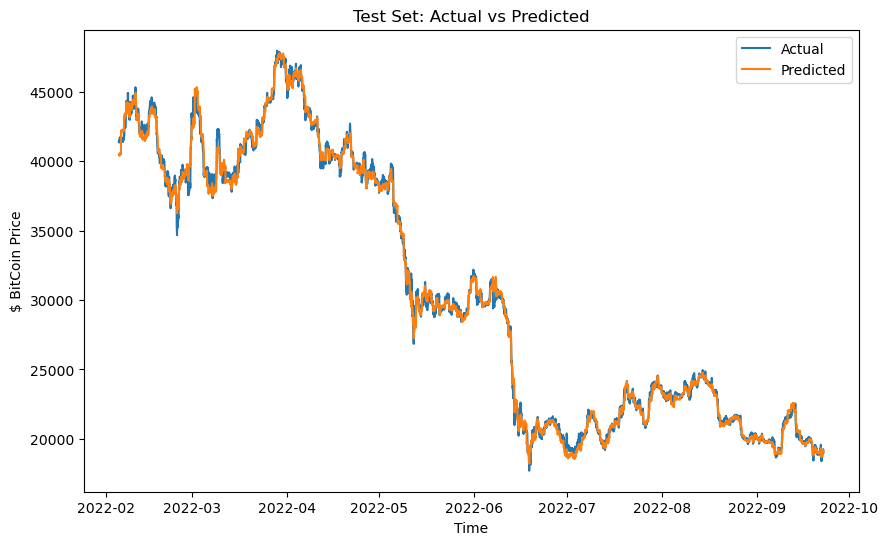

In [48]:
# Get the predicted values


# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, lasso_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## Lasso 2 - using only price features

In [49]:
from sklearn.linear_model import Lasso
lasso2 = Lasso(alpha=0.1)
lasso2.fit(X_train[:,accessible], y_train)

C:\Users\jiadiz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e+09, tolerance: 1.923e+09



Lasso(alpha=0.1)

In [50]:
df = pd.DataFrame({'real_price':y_valid, 'pred_price':lasso2_val_pred})

NameError: name 'lasso2_val_pred' is not defined

In [51]:
lasso2_val_pred = lasso2.predict(X_valid[:,accessible])
calculate_metrics(y_valid,lasso2_val_pred)

The MAE is 289.11257762356485.  
The RMSE is 391.29621750022045.  
The r_squared is 0.9982686791510843.


## Ridge 1 - using all features

This model uses all available features

In [53]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1)

ridge.fit(X_train, y_train)


ridge_val_pred = ridge.predict(X_valid)


In [54]:
ridge_train_pred = ridge.predict(X_train)
calculate_metrics(y_train, ridge_train_pred)

The MAE is 38.890994540560435.  
The RMSE is 125.03658744755623.  
The r_squared is 0.9999194517158492.


The MAE is 132.07324052088418.  
The RMSE is 200.45250341400416.  
The r_squared is 0.9995430045316717.


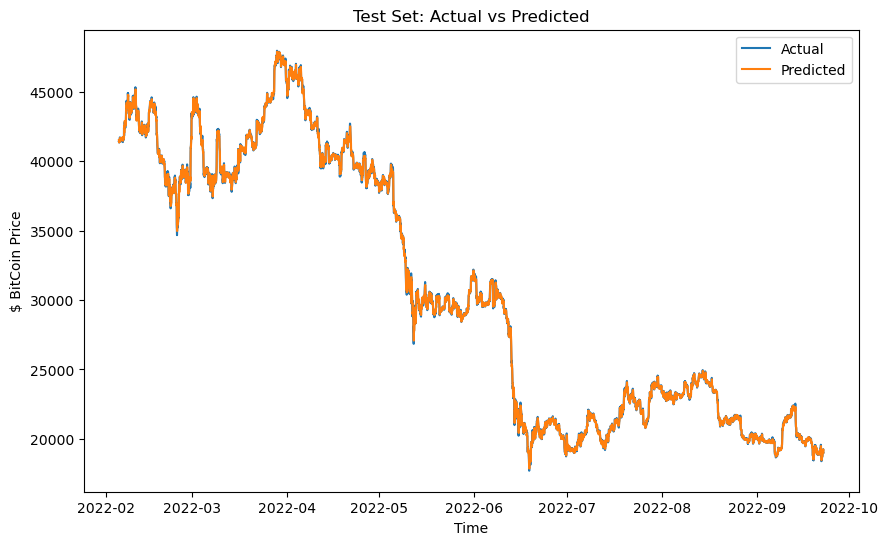

In [55]:
calculate_metrics(y_valid, ridge_val_pred)

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, ridge_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## Ridge 2 - using only price features.

In [56]:
from sklearn.linear_model import Ridge
ridge2 = Ridge(alpha=1)

ridge2.fit(X_train[:,accessible], y_train)

ridge2_val_pred = ridge2.predict(X_valid[:,accessible])

The MAE is 132.15999671924877.  
The RMSE is 200.50176844623928.  
The r_squared is 0.9995428713824807.


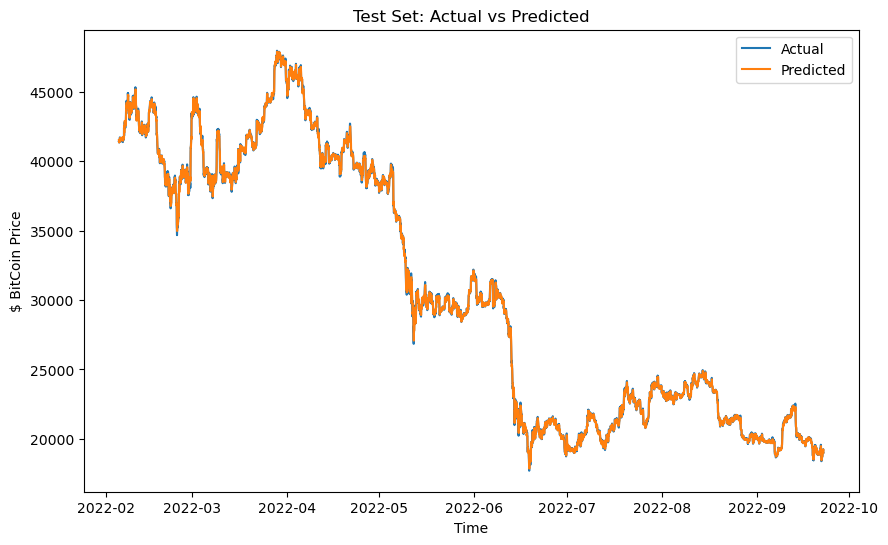

In [57]:
calculate_metrics(y_valid, ridge2_val_pred)

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, ridge2_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

The MAE is 65.08717814557909.  
The RMSE is 110.97944387154071.  
The r_squared is 0.9993647014791381.


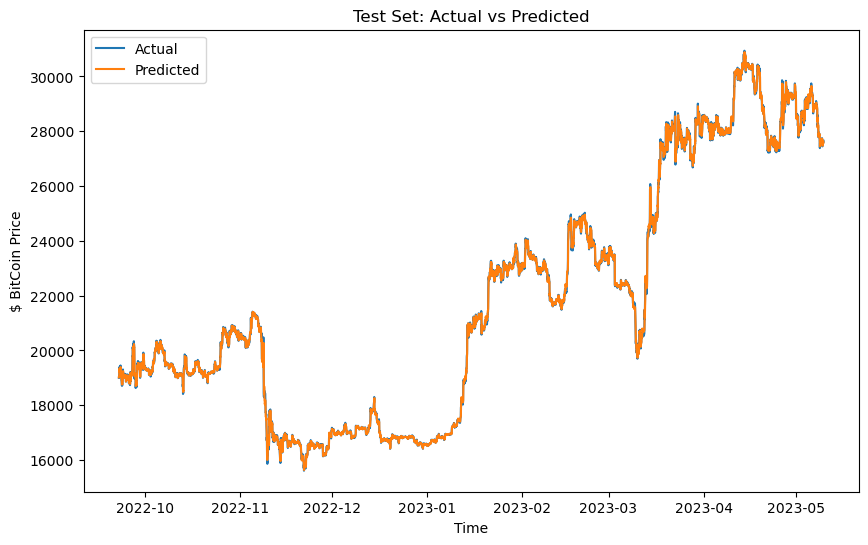

In [58]:
ridge2_test_pred = ridge2.predict(X_test[:,accessible])

calculate_metrics(y_test, ridge2_test_pred)

plt.figure(figsize=(10,6))
plt.plot(y_test_d.index, y_test, label='Actual')
plt.plot(y_test_d.index, ridge2_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

## Ridge 3: using only price features to predict price change

In [59]:
y_train_c = np.array([y_train[i] - y_train[i-1] for i in range(1,len(y_train))])
y_valid_c = np.array([y_valid[i] - y_valid[i-1] for i in range(1,len(y_valid))])
y_test_c = np.array([y_test[i] - y_test[i-1] for i in range(1,len(y_test))])       

In [60]:

ridge3 = Ridge(alpha=1)

ridge3.fit(X_train[1:,accessible],  y_train_c)


ridge3_val_pred = ridge3.predict(X_valid[1:,accessible])

calculate_metrics(ridge3_val_pred, y_valid_c)


The MAE is 130.44162207809518.  
The RMSE is 199.1729778395267.  
The r_squared is 0.07582113689753334.


We also transform the predicted price change into prices. 

In [61]:
ridge3_val_pred = ridge3_val_pred + y_valid[:len(y_valid)-1]

In [64]:
calculate_metrics(ridge3_val_pred,y_valid[1:])

The MAE is 130.44162207809518.  
The RMSE is 199.1729778395267.  
The r_squared is 0.9995489233089528.


# Tree-based models

## Random Forest 1 - using all features

random searching for the best hyperparameter:


The random search process is too long, thus it is commented out. The hyperparameters are put directly into the models.

In [66]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
#     'learning_rate': [0.01, 0.05 ,0.1, 0.2, 0.3 ,0.5],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 2, 3, 4,5],
#     'gamma': [0.0, 0.05, 0.1,0.15, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0.0, 0.1, 0.2, 0.5],
#     'reg_lambda': [0.0, 0.1, 0.2, 0.5]
# }

# # Create an XGBoost regressor object
# xgb = XGBRegressor()

# # Split your data into training and testing sets

# # Perform random search
# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_xgb = rf_random_search.best_estimator_)

In [67]:
rf = RandomForestRegressor(n_estimators=200,n_jobs=-1,max_depth = 15,bootstrap=True,
                           verbose=5,random_state=123)
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s


building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min


building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building t

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min


building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.4min finished


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=123, verbose=5)

In [68]:
rf_val_pred = rf.predict(X_valid)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [69]:
calculate_metrics(y_valid, rf_val_pred)

The MAE is 513.5348508632944.  
The RMSE is 690.6167308239767.  
The r_squared is 0.9940280869882666.


We can see that the model degrades quickly since the model starts to fail capturing the price after may 2022. 

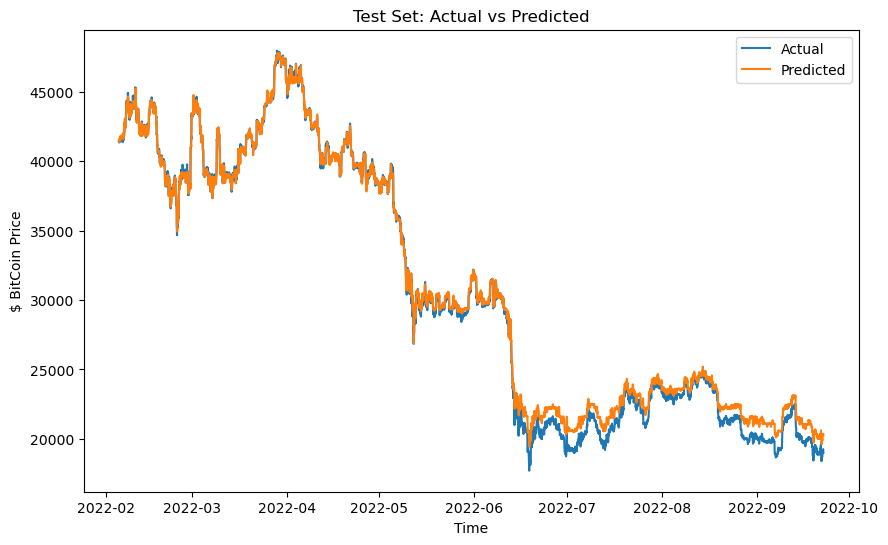

In [70]:

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, rf_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## Random Forest 2 - using only price features

In [72]:
rf2 = RandomForestRegressor(n_estimators=200,n_jobs=-1,max_depth = 15,bootstrap=True,
                           verbose=5,random_state=123)
rf2.fit(X_train[:,accessible],y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s


building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.7s


building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building t

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min


building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=123, verbose=5)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


The MAE is 491.62919286167653.  
The RMSE is 662.6836312922647.  
The r_squared is 0.994536658115031.


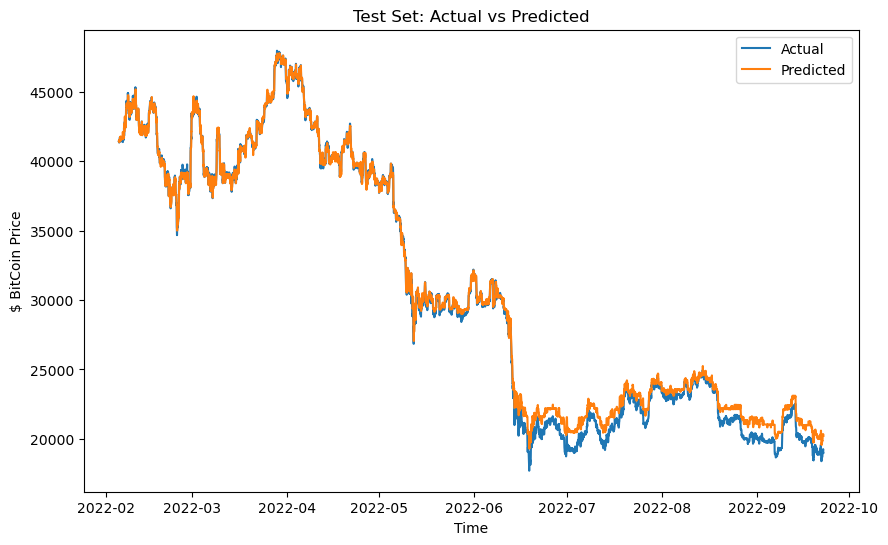

In [73]:

rf2_val_pred = rf2.predict(X_valid[:,accessible])
calculate_metrics(y_valid, rf2_val_pred)

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, rf2_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


It looks OK but a little bit off from 2022-11 to 2022-12, let's see if there is a way to tune the model.

## XGB - using all features

The random search process is too long, thus it is commented out. The hyperparameters are put directly into the models.

In [74]:
from xgboost import XGBRegressor

In [75]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
#     'learning_rate': [0.01, 0.05 ,0.1, 0.2, 0.3 ,0.5],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 2, 3, 4,5],
#     'gamma': [0.0, 0.05, 0.1,0.15, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0.0, 0.1, 0.2, 0.5],
#     'reg_lambda': [0.0, 0.1, 0.2, 0.5]
# }

# # Create an XGBoost regressor object
# xgb = XGBRegressor()

# # Split your data into training and testing sets

# # Perform random search
# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_xgb = rf_random_search.best_estimator_)

In [76]:
# rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
#                            verbose=5,random_state=123)

# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5, 7, None],
#     'min_samples_split': [2, 4, 6,8 , 10],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# # Create a Random Forest regressor object
# rf = RandomForestRegressor()



# # Perform random search
# rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# rf_random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_rf = random_search.best_estimator_

In [77]:
# It takes too long, I will comment them first
# grid_search.fit(X_train, y_train) 
# grid_search.best_params_ 
# # {'n_estimators': 500}

In [78]:
xgb=XGBRegressor(subsample = 0.6, reg_lambda= 0.2, n_estimators = 250, min_child_weight= 3, max_depth = 8, learning_rate = 0.03, gamma = 0.05, colsample_bytree = 1.0)

In [79]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [80]:
xgb_val_pred = xgb.predict(X_valid)

In [81]:
calculate_metrics(y_valid,xgb_val_pred
)


The MAE is 397.6198013180938.  
The RMSE is 531.2587647710704.  
The r_squared is 0.9965539667521938.


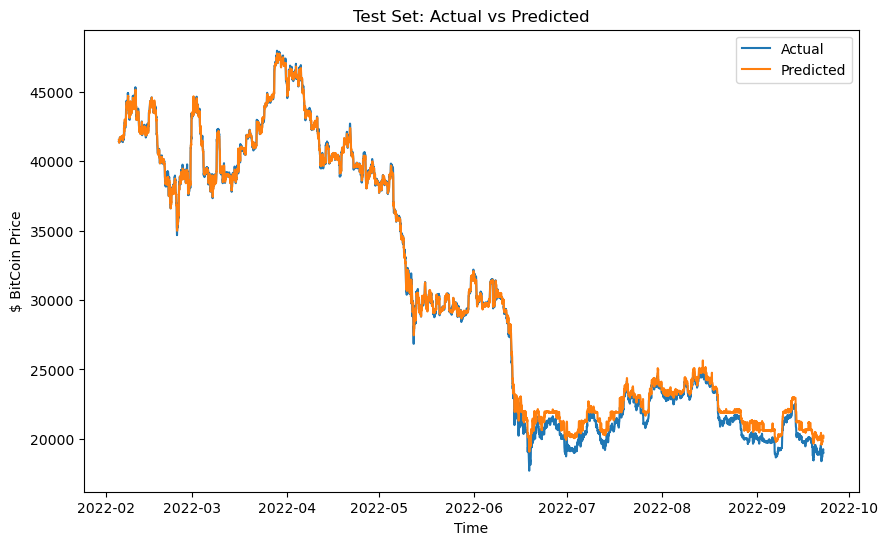

In [82]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, xgb_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## XGB 2 - using only price features

In [83]:
xgb2=XGBRegressor(subsample = 0.6, reg_lambda= 0.2, n_estimators = 250, min_child_weight= 3, max_depth = 8, learning_rate = 0.03, gamma = 0.05, colsample_bytree = 1.0)
xgb2.fit(X_train[:,accessible], y_train)
xgb2_val_pred = xgb2.predict(X_valid[:,accessible])

In [84]:
calculate_metrics(y_valid,xgb2_val_pred
)


The MAE is 385.84046596021165.  
The RMSE is 514.689235172919.  
The r_squared is 0.9967734282690289.


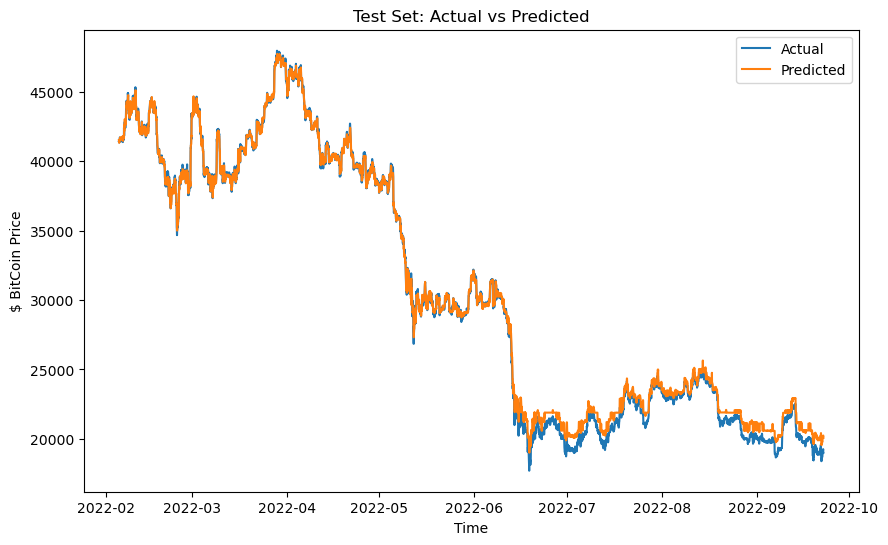

In [85]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, xgb2_val_pred , label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

# Neural net 

## MLP 1 - using all features

In [86]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from scipy.stats import randint

code for hyper parameter tuning (commented out to save time):

In [87]:
mlp = MLPRegressor(hidden_layer_sizes=[100,100,100,100,100,100], activation = 'relu', learning_rate = 'adaptive', alpha = 0.01, max_iter = 150, random_state=42)
mlp.fit(X_train, y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=[100, 100, 100, 100, 100, 100],
             learning_rate='adaptive', max_iter=150, random_state=42)

In [88]:
mlp_val_pred = mlp.predict(X_valid)

In [89]:
calculate_metrics(y_valid, mlp_val_pred)

The MAE is 800.2444690105226.  
The RMSE is 997.0885720448591.  
The r_squared is 0.9872328457887553.


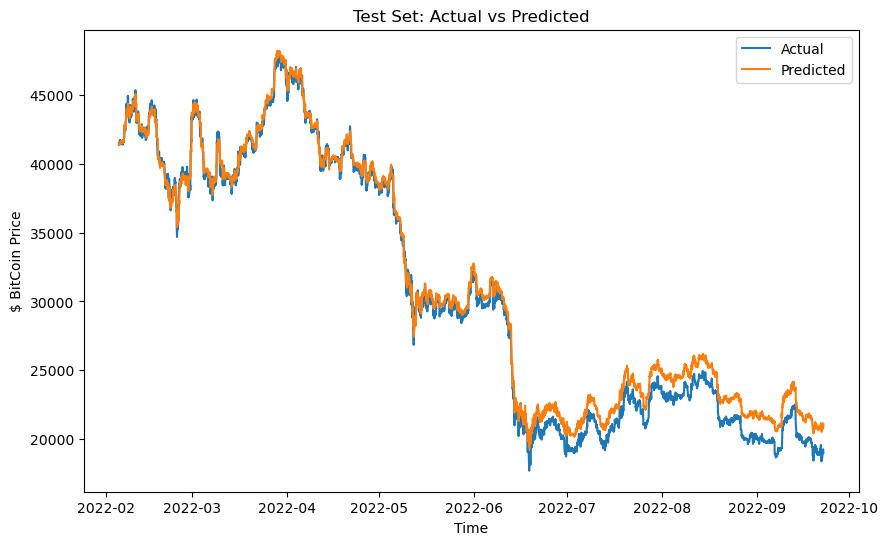

In [90]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, mlp_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## MLP 2 - using only price features to predict price change 

In [93]:
mlp2 = MLPRegressor(hidden_layer_sizes=[100,100,100,100,100,100], activation = 'relu', learning_rate = 'adaptive', alpha = 0.01, max_iter = 150, random_state=42)

mlp2.fit(X_train[1:,accessible],  y_train_c)


mlp2_val_pred = mlp2.predict(X_valid[1:,accessible])
mlp2_test_pred = mlp2.predict(X_test[1:,accessible])

calculate_metrics(mlp2_val_pred, y_valid_c)

The MAE is 130.00152110105913.  
The RMSE is 202.31936455420123.  
The r_squared is 0.04639152299210492.


In [94]:
mlp2_val_pred = mlp2_val_pred + y_valid[:len(y_valid)-1]

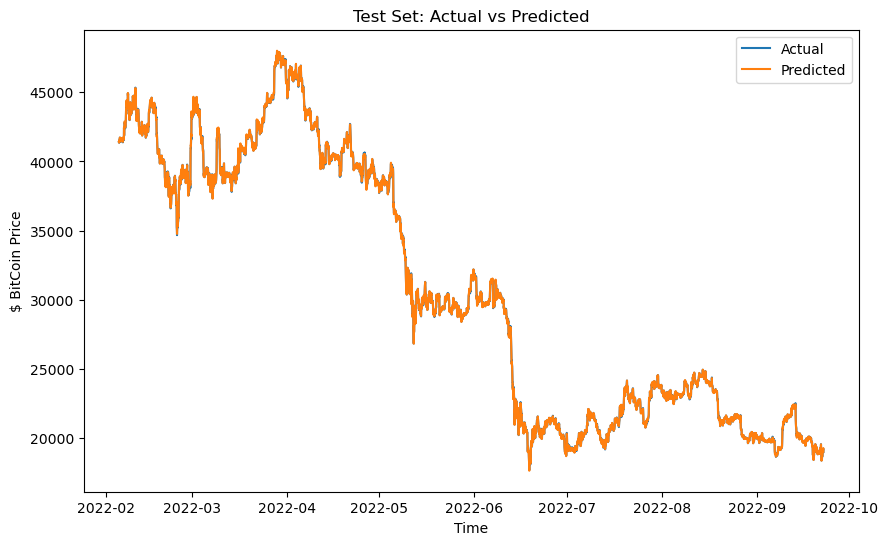

In [95]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d[:len(y_valid)-1].index, y_valid[:len(y_valid)-1], label='Actual')
plt.plot(y_valid_d[:len(y_valid)-1].index, mlp2_val_pred , label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

## LSTM 1 - using all features

In [561]:
def transform(X_array, y_array, sequence_length = 4):

    X_array_reshaped = np.zeros((X_array.shape[0] - sequence_length + 1, sequence_length, X_array.shape[1]))

    for i in range(sequence_length):
        X_array_reshaped[:, i, :] = X_array[i : X_array.shape[0] - sequence_length + 1 + i, :]

    y_array_reshaped = y_array[sequence_length - 1:]
    print(X_array_reshaped.shape)
    print(y_array_reshaped.shape)
    return X_array_reshaped, y_array_reshaped

In [1049]:
X_train_reshaped, y_train_reshaped = transform(X_train, y_train)
X_valid_reshaped, y_valid_reshaped = transform(X_valid, y_valid)
X_test_reshaped, y_test_reshaped = transform(X_test, y_test)

(99076, 4, 108)
(99076,)
(5501, 4, 108)
(5501,)
(5502, 4, 108)
(5502,)


In [563]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras import regularizers

input_dim = X_train_reshaped.shape[2]
timesteps = 4
hidden_layers = 3
epoch = 100
neurons = 200

model = Sequential()
model.add(LSTM(neurons, activation = 'relu', kernel_regularizer=regularizers.l2(0.1), input_shape=(timesteps, input_dim), return_sequences=True))  # Adjust the number of units (128) as per your requirements

for i in range(hidden_layers):
    model.add(LSTM(neurons, activation = 'relu' ,return_sequences=True))
              
model.add(LSTM(neurons, activation ='relu'))
model.add(Dense(1))  


model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the optimizer and loss function as needed



In [556]:
model.fit(X_train_reshaped, y_train_reshaped, epochs=epoch, batch_size=32)  # Adjust the number of epochs and batch size as per your dataset

Load the trained weight

In [564]:
model.load_weights('lstm_model.h5')

In [1045]:
lstm_val_pred = model.predict(X_valid_reshaped)

172/172 [==============================] - 2s 12ms/step


In [632]:
calculate_metrics(lstm_val_pred,y_valid_reshaped)

The MAE is 374.47381448085116.  
The RMSE is 486.68025517319535.  
The r_squared is 0.9973064494660966.


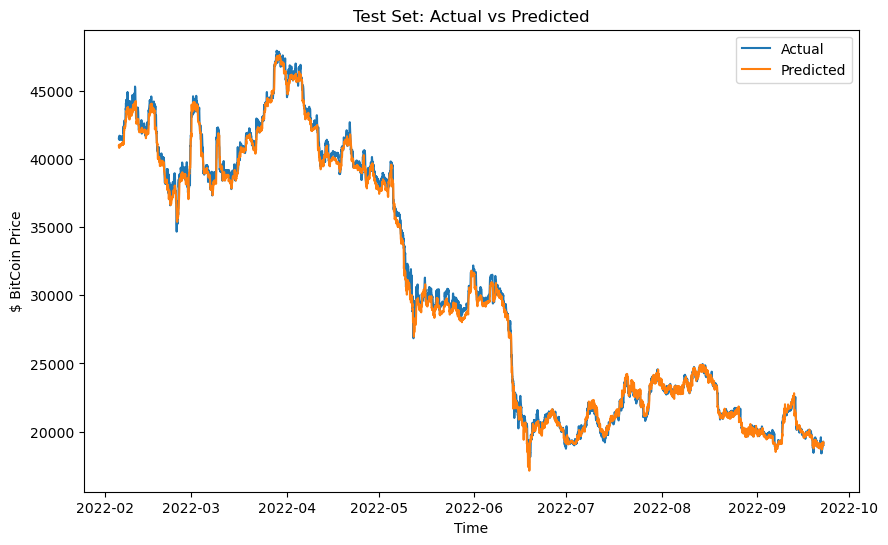

In [633]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d[len(y_valid)-len(predictions):].index, y_valid_reshaped, label='Actual')
plt.plot(y_valid_d[len(y_valid)-len(predictions):].index, lstm_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

## LSTM 2 - using a new set of price features

LSTM done with only time series data

In [947]:
df1 = pd.read_csv('data/bitcoin-price-usd.csv')

In [948]:
df1['date'] = pd.to_datetime(df1['timestamp']).dt.date

In [717]:
df1['hour'] = pd.to_datetime(df1['timestamp']).dt.hour

In [718]:
df1['date'] = (pd.to_datetime(df1['date'])-pd.to_datetime('2010-7-17')).dt.days

In [721]:
df1 = df1[df['date'] > '2010-10-17']

timestamp         value  date  hour
0       2010-07-17T23:00:00Z      0.049510     0    23
1       2010-07-18T00:00:00Z      0.049510     1     0
2       2010-07-18T01:00:00Z      0.049510     1     1
3       2010-07-18T02:00:00Z      0.049510     1     2
4       2010-07-18T03:00:00Z      0.059410     1     3
...                      ...           ...   ...   ...
112325  2023-05-11T04:00:00Z  27512.016824  4681     4
112326  2023-05-11T05:00:00Z  27548.006729  4681     5
112327  2023-05-11T06:00:00Z  27512.564596  4681     6
112328  2023-05-11T07:00:00Z  27448.817765  4681     7
112329  2023-05-11T08:00:00Z  27419.845123  4681     8

[112330 rows x 4 columns]

In [723]:
df1 = df1.set_index('timestamp')

In [7]:
def feature_engineering2(df, days = 100, sequence_length = 5):
    df['prev_price'] = df['value']
    for i in range(1,days//sequence_length + 1):
        value = i * sequence_length
        df['prev_price_'+ str(value)] =df['value'].shift(value)
    df = df.dropna()
    return df
        
    

In [8]:
df1 = feature_engineering2(df1,sequence_length = 3, days = 100)

In [9]:
y2 = df1['value']
X2 = df1.drop(['value'],axis = 1)

In [10]:
X2_dataframe = X2
y2_dataframe = y2

In [446]:
y2 = np.array(y2)

In [448]:
X2_length = X2.shape[0]
split1 = int(X2_length * 0.90)
split2 = int(X2_length * 0.95)


X2_train, X2_valid, X2_test = X2[:split1], X2[split1:split2],X2[split2:]

y2_train, y2_valid, y2_test = y2[:split1], y2[split1:split2],y2[split2:]

X2_train_d, X2_valid_d, X2_test_d = X2_dataframe[:split1], X2_dataframe[split1:split2],X2_dataframe[split2:]

y2_train_d, y2_valid_d, y2_test_d = y2_dataframe[:split1], y2_dataframe[split1:split2],y2_dataframe[split2:]

In [455]:
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()

scaler2.fit(X2_train)

X2_train = scaler2.transform(X2_train)
X2_valid = scaler2.transform(X2_valid)
X2_test = scaler2.transform(X2_test)

In [259]:
def transform(X_array, y_array, sequence_length = 3):

    X_array_reshaped = np.zeros((X_array.shape[0] - sequence_length + 1, sequence_length, X_array.shape[1]))

    for i in range(sequence_length):
        X_array_reshaped[:, i, :] = X_array[i : X_array.shape[0] - sequence_length + 1 + i, :]

    y_array_reshaped = y_array[sequence_length - 1:]
    print(X_array_reshaped.shape)
    print(y_array_reshaped.shape)
    return X_array_reshaped, y_array_reshaped

In [264]:
X2_train_reshaped, y2_train_reshaped = transform(X2_train,y2_train, sequence_length = 3)

(101005, 3, 36)
(101005,)


In [571]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras import regularizers
from keras.optimizers import Adam

input_dim = X2_train_reshaped.shape[2]
hidden_layers = 3
epoch = 45
neurons = 200

model2 = Sequential()
model2.add(LSTM(neurons, activation = 'relu', kernel_regularizer=regularizers.l2(0.1), input_shape=(sequence_length, input_dim), return_sequences=True))  # Adjust the number of units (128) as per your requirements

for i in range(hidden_layers):
    model2.add(LSTM(neurons, activation = 'relu' ,return_sequences=True))
              
model2.add(LSTM(neurons, activation ='relu'))
model2.add(Dense(1))  


model2.compile(optimizer='adam', loss='mean_squared_error') 

In [14]:
model2.fit(X2_train_reshaped, y2_train_reshaped, epochs=epoch, batch_size=32)  

Epoch 1/15
3157/3157 [==============================] - 104s 31ms/step - loss: 3223129.0000
Epoch 2/15
3157/3157 [==============================] - 93s 29ms/step - loss: 453867.5312
Epoch 3/15
3157/3157 [==============================] - 93s 30ms/step - loss: 400529.5938
Epoch 4/15
3157/3157 [==============================] - 93s 29ms/step - loss: 314635.8438
Epoch 5/15
3157/3157 [==============================] - 91s 29ms/step - loss: 261031.2812
Epoch 6/15
3157/3157 [==============================] - 82s 26ms/step - loss: 215179.4375
Epoch 7/15
3157/3157 [==============================] - 81s 26ms/step - loss: 202490.1875
Epoch 8/15
3157/3157 [==============================] - 92s 29ms/step - loss: 171772.0938
Epoch 9/15
3157/3157 [==============================] - 96s 30ms/step - loss: 155063.5000
Epoch 10/15
3157/3157 [==============================] - 91s 29ms/step - loss: 125273.4219
Epoch 11/15
3157/3157 [==============================] - 93s 30ms/step - loss: 128770.3047
Epoch 

In [15]:
model.fit(X2_train_reshaped, y2_train_reshaped, epochs=20, batch_size=32) 

Epoch 1/20
3157/3157 [==============================] - 94s 30ms/step - loss: 134149.7188
Epoch 2/20
3157/3157 [==============================] - 103s 33ms/step - loss: 84241.3203
Epoch 3/20
3157/3157 [==============================] - 89s 28ms/step - loss: 98610.5781
Epoch 4/20
3157/3157 [==============================] - 81s 26ms/step - loss: 80981.1016
Epoch 5/20
3157/3157 [==============================] - 81s 26ms/step - loss: 95737.6094
Epoch 6/20
3157/3157 [==============================] - 80s 25ms/step - loss: 64881.4492
Epoch 7/20
3157/3157 [==============================] - 95s 30ms/step - loss: 63647.1875
Epoch 13/20
3157/3157 [==============================] - 92s 29ms/step - loss: 57709.4961
Epoch 14/20
3157/3157 [==============================] - 93s 29ms/step - loss: 60855.5781
Epoch 15/20
3157/3157 [==============================] - 93s 30ms/step - loss: 56863.5742
Epoch 16/20
3157/3157 [==============================] - 93s 30ms/step - loss: 57409.8047
Epoch 17/20
315

In [132]:
model.fit(X2_train_reshaped, y2_train_reshaped, epochs=10, batch_size=32) 

Epoch 1/10
3157/3157 [==============================] - 90s 29ms/step - loss: 40050.8320
Epoch 2/10
3157/3157 [==============================] - 92s 29ms/step - loss: 36379.4453
Epoch 3/10
3157/3157 [==============================] - 93s 29ms/step - loss: 32190.7559
Epoch 4/10
3157/3157 [==============================] - 105s 33ms/step - loss: 42696.5977
Epoch 5/10
3157/3157 [==============================] - 103s 33ms/step - loss: 29172.8574
Epoch 6/10
3157/3157 [==============================] - 100s 32ms/step - loss: 30636.4766
Epoch 7/10
3157/3157 [==============================] - 91s 29ms/step - loss: 28182.4336
Epoch 8/10
3157/3157 [==============================] - 91s 29ms/step - loss: 23006.9414
Epoch 9/10
3157/3157 [==============================] - 106s 34ms/step - loss: 28886.9863
Epoch 10/10
3157/3157 [==============================] - 102s 32ms/step - loss: 30290.3066


In [573]:
model2.load_weights('lstm_model3.h5')

In [575]:
predictions = model2.predict(X2_valid_reshaped)

176/176 [==============================] - 2s 9ms/step


In [576]:
lstm2_val_pred = predictions.squeeze(1)
calculate_metrics(lstm2_val_pred, y2_valid_reshaped)

The MAE is 110.33021161330453.  
The RMSE is 151.34848281215758.  
The r_squared is 0.9997340749562829.


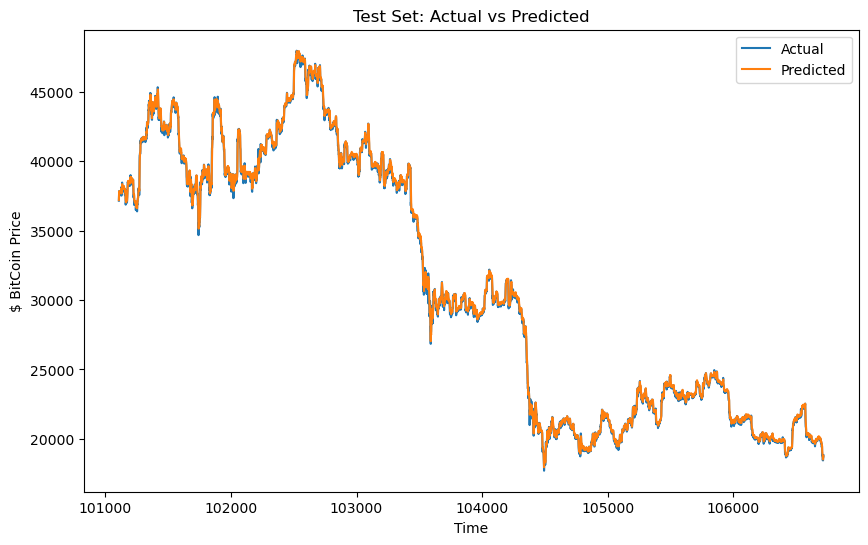

In [577]:
plt.figure(figsize=(10,6))
plt.plot(y2_valid_reshaped.index, y2_valid_reshaped, label='Actual')
plt.plot(y2_valid_reshaped.index, lstm2_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

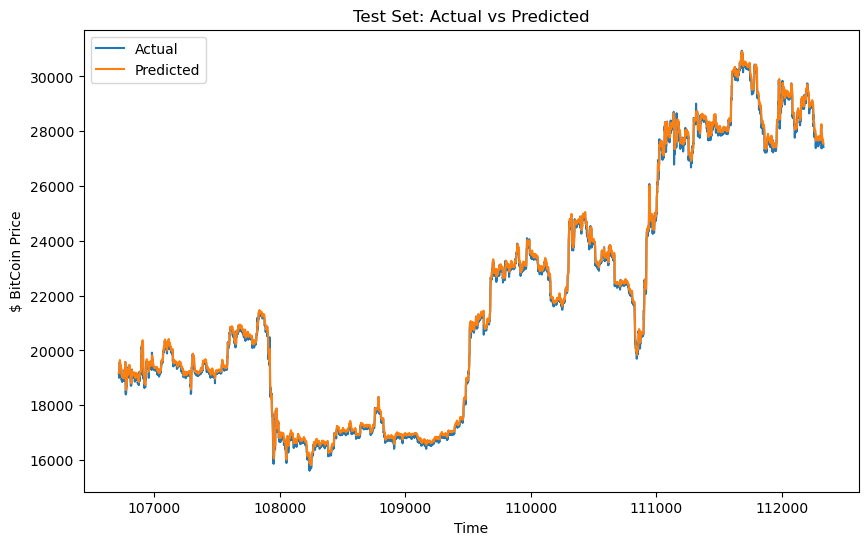

In [174]:
plt.figure(figsize=(10,6))
plt.plot(y2_test_reshaped.index, y2_test_reshaped, label='Actual')
plt.plot(y2_test_reshaped.index, lstm2_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

# Back test with the validation sets from the 3 models

In [935]:
val_outputs = (ridge_val_pred, ridge2_val_pred, ridge3_val_pred, lasso_val_pred, lasso2_val_pred, rf_val_pred, rf2_val_pred, xgb_val_pred, xgb2_val_pred, mlp_val_pred, mlp2_val_pred, lstm_val_pred)

column_names =['ridge_val_pred', 'ridge2_val_pred', 'ridge3_val_pred', 'lasso_val_pred', 'lasso2_val_pred', 'rf_val_pred', 'rf2_val_pred', 'xgb_val_pred', 'xgb2_val_pred', 'mlp_val_pred', 'mlp2_val_pred', 'lstm_val_pred']

min_length = min([len(output) for output in val_outputs])

val_df = pd.DataFrame({'real_price': y_valid})

starting_position = len(val_df) - min_length

val_df = val_df.iloc[starting_position:,]

In [974]:
for output, column_name in zip(val_outputs,column_names):
    starting_position = len(output) - min_length
    print(column_name)
    val_df[column_name] = output[starting_position:] 
val_df['average_predicted_price'] = val_df.iloc[:,1:].mean(axis=1)

ridge_val_pred
ridge2_val_pred
ridge3_val_pred
lasso_val_pred
lasso2_val_pred
rf_val_pred
rf2_val_pred
xgb_val_pred
xgb2_val_pred
mlp_val_pred
mlp2_val_pred
lstm_val_pred


In [975]:
val_df = val_df.reset_index(drop = True)

In [978]:
lstm_df = pd.DataFrame({'real_price':y2_valid_reshaped,'lstm2_val_pred':lstm2_val_pred}).reset_index(drop = True)

In [979]:
def back_test(df):
    for colname in df.columns[0:]:
        money = 50000
        coins = 2 
        for i in range(len(df)-1):

            if df[colname][i+1] > df['real_price'][i]:
                coins += money/df['real_price'][i] 
                money = 0
                
            elif df[colname][i+1] < df['real_price'][i]:
                money += coins * df['real_price'][i]
                coins = 0
        final_asset_level = max(money, coins*df['real_price'][len(df)-1])
        initial_asset_level = 50000 + 2*df['real_price'][0]
        asset_growth = (final_asset_level - initial_asset_level) /  initial_asset_level
        print( 'The asset growth rate would be ' + str( round(asset_growth*100,2)) + '% if trades were conducted upon ' +str(colname) + ' in a ' + str(round(len(df)/24,2)) + 'days period')

In [980]:
back_test(val_df)

The asset growth rate would be 11692545.25% if trades were conducted upon real_price in a 229.21days period
The asset growth rate would be 4669.47% if trades were conducted upon ridge_val_pred in a 229.21days period
The asset growth rate would be 4705.66% if trades were conducted upon ridge2_val_pred in a 229.21days period
The asset growth rate would be 5240.88% if trades were conducted upon ridge3_val_pred in a 229.21days period
The asset growth rate would be 324.94% if trades were conducted upon lasso_val_pred in a 229.21days period
The asset growth rate would be 274.31% if trades were conducted upon lasso2_val_pred in a 229.21days period
The asset growth rate would be 74.64% if trades were conducted upon rf_val_pred in a 229.21days period
The asset growth rate would be 73.48% if trades were conducted upon rf2_val_pred in a 229.21days period
The asset growth rate would be 190.74% if trades were conducted upon xgb_val_pred in a 229.21days period
The asset growth rate would be 149.1% i

In [972]:
back_test(lstm_df)

The asset growth rate would be 14979790.87% if trades were conducted upon real_price in a 233.75days period
The asset growth rate would be 107572.47% if trades were conducted upon lstm2_val_pred in a 233.75days period


As shown in the simulation conducted upon the validation set, ridge, and LSTM have shown superior result. 
Now we will conduct the final test on the test set to test the robustness of all the models, which could root out all the models that are overfitted or would show signs of degradation. 

# Final Test

Ridge

In [1058]:
ridge_test_pred = ridge.predict(X_test)
calculate_metrics(y_test,ridge_test_pred)

The MAE is 64.98348680886056.  
The RMSE is 110.98786433172327.  
The r_squared is 0.9993646456905821.


In [1059]:
ridge2_test_pred = ridge2.predict(X_test[:,accessible])
calculate_metrics(ridge2_test_pred, y_test)

The MAE is 65.08717814557909.  
The RMSE is 110.97944387154071.  
The r_squared is 0.9993645611849641.


In [1060]:
pred_change = ridge3.predict(X_test[1:,accessible])
ridge3_test_pred = pred_change + y_test[0:len(y_test)-1]
calculate_metrics(ridge3_test_pred, y_test[1:])

The MAE is 64.02046003022532.  
The RMSE is 110.4518112559874.  
The r_squared is 0.9993706568570188.


LSTM

In [1050]:
predictions = model.predict(X_test_reshaped)
lstm_test_pred = predictions.squeeze(1)
calculate_metrics(lstm_test_pred, y_test_reshaped)

172/172 [==============================] - 2s 12ms/step
The MAE is 505.94959075952687.  
The RMSE is 636.4836909985934.  
The r_squared is 0.9791060666344716.


In [1051]:
predictions = model2.predict(X2_test_reshaped)
lstm2_test_pred = predictions.squeeze(1)
calculate_metrics(lstm2_test_pred, y2_test_reshaped)

176/176 [==============================] - 2s 10ms/step
The MAE is 91.1275674139914.  
The RMSE is 109.76925276461768.  
The r_squared is 0.9993762957934821.


In [1113]:
test_outputs = (ridge_test_pred, ridge2_test_pred, ridge3_test_pred,lstm_test_pred,mlp2_test_pred)
column_names =['ridge_test_pred', 'ridge2_test_pred', 'ridge3_test_pred','lstm_test_pred','mlp2_test_pred']

min_length = min([len(output) for output in test_outputs])

test_df = pd.DataFrame({'real_price': y_test})

starting_position = len(test_df) - min_length

test_df = test_df.iloc[starting_position:,]

for output, column_name in zip(test_outputs,column_names):
    starting_position = len(output) - min_length
    print(column_name)
    test_df[column_name] = output[starting_position:] 
test_df['average_predicted_price'] = test_df.iloc[:,1:].mean(axis=1)
test_df = test_df.reset_index(drop = True)

ridge_test_pred
ridge2_test_pred
ridge3_test_pred
lstm_test_pred
mlp2_test_pred


In [1109]:
lstm_test_df = pd.DataFrame({'real_price':y2_test_reshaped,'lstm2_val_pred':lstm2_test_pred}).reset_index(drop = True)

In [1110]:
back_test(test_df)

The asset growth rate would be 269695.32% if trades were conducted upon real_price in a 229.25days period
The asset growth rate would be 3021.11% if trades were conducted upon ridge_test_pred in a 229.25days period
The asset growth rate would be 2719.01% if trades were conducted upon ridge2_test_pred in a 229.25days period
The asset growth rate would be 3156.25% if trades were conducted upon ridge3_test_pred in a 229.25days period
The asset growth rate would be 184.2% if trades were conducted upon lstm_test_pred in a 229.25days period
The asset growth rate would be 710.26% if trades were conducted upon mlp2_test_pred in a 229.25days period
The asset growth rate would be 280.44% if trades were conducted upon average_predicted_price in a 229.25days period


In [1074]:
back_test(lstm_test_df)

The asset growth rate would be 339145.5% if trades were conducted upon real_price in a 233.75days period
The asset growth rate would be 2860.27% if trades were conducted upon lstm2_val_pred in a 233.75days period


lstm and ridge performed equally well in the simulation. Now lets check at the graphs of the outputs to examine which model is less likely to experience degradation.

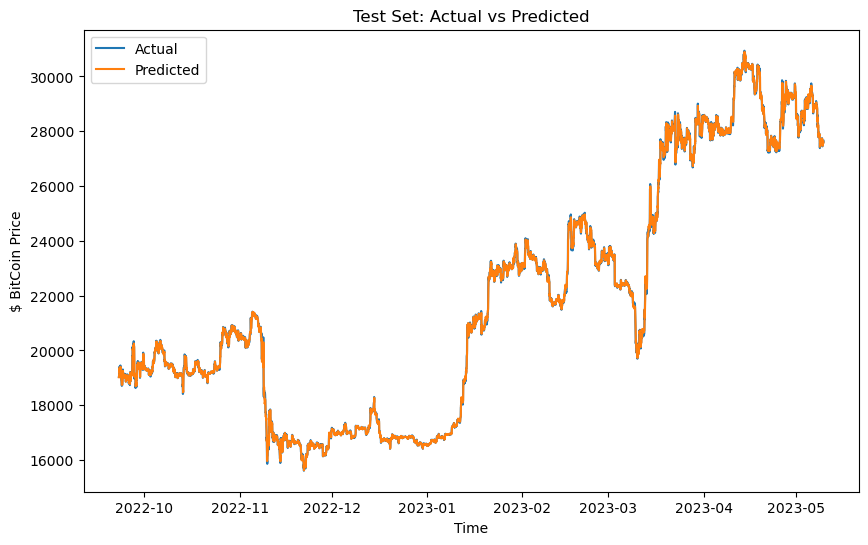

In [1084]:

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test_d[1:].index, y_test[1:], label='Actual')
plt.plot(y_test_d[1:].index, ridge3_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

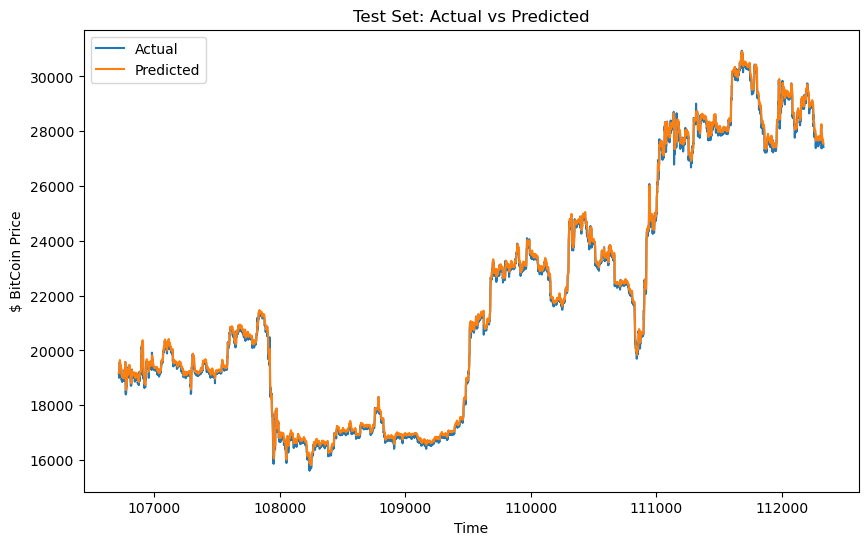

In [1086]:
plt.figure(figsize=(10,6))
plt.plot(y2_test_d[sequence_length -1:].index, y2_test_reshaped, label='Actual')
plt.plot(y2_test_d[sequence_length -1:].index, lstm2_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

# Conclusion

We can see from the graphs that the LSTM's outputs experiences more deviation from the actual price in the later stage of the prediction. Therefore, the LSTM model is more likely to degrade over-time and is more over-fitted to the training and validation set. Therefore, among all the models fitted in this project, ridge is the ideal model to be used for hourly-frequency trading.

# Bonus

## Test performances of other models

The other models performed positively because the overall price of bitcoin increased drastically during the time of the test data set, enabling any model to earn money despite low R-squared. 

Tests of other models:

In [1090]:
rf_test_pred = rf.predict(X_test)
calculate_metrics(rf_test_pred, y_test)

The MAE is 764.0418794689853.  
The RMSE is 886.8432718232984.  
The r_squared is 0.9594227694676492.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [1091]:
rf2_test_pred = rf2.predict(X_test[:,accessible])
calculate_metrics(rf2_test_pred, y_test)

The MAE is 742.5007371072934.  
The RMSE is 870.4954825548133.  
The r_squared is 0.9609049570438533.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [1092]:
xgb_test_pred = xgb.predict(X_test)
calculate_metrics(xgb_test_pred, y_test)

The MAE is 620.8531316666765.  
The RMSE is 718.052381416528.  
The r_squared is 0.9733988198078698.


In [1093]:
xgb2_test_pred = xgb2.predict(X_test[:,accessible])
calculate_metrics(xgb2_test_pred, y_test)

The MAE is 596.7354929344945.  
The RMSE is 694.8106987194667.  
The r_squared is 0.9750929871107112.


In [1094]:
mlp_test_pred = mlp.predict(X_test)
calculate_metrics(mlp_test_pred, y_test)

The MAE is 2520.180648835478.  
The RMSE is 2568.692037072926.  
The r_squared is 0.6595818320572657.


In [1106]:
mlp2_test_pred = mlp2.predict(X_test[1:,accessible])
mlp2_test_pred = mlp2_test_pred + y_test[:len(y_test)-1]
calculate_metrics(mlp2_test_pred, y_test[1:])

The MAE is 63.44396159652022.  
The RMSE is 112.68312136917048.  
The r_squared is 0.9993449724631951.


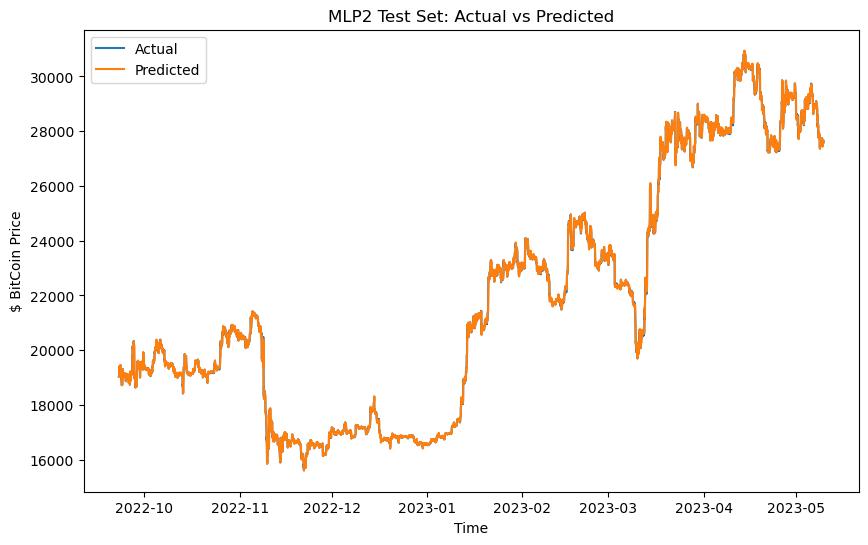

In [1141]:
plt.figure(figsize=(10,6))
plt.plot(y_test_d[1:].index, y_test[1:], label='Actual')
plt.plot(y_test_d[1:].index, mlp2_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('MLP2 Test Set: Actual vs Predicted')
plt.show()

In [1114]:
test_outputs = (rf_test_pred, rf2_test_pred, xgb_test_pred, xgb2_test_pred , mlp_test_pred, mlp2_test_pred)
column_names =['rf_test_pred', 'rf2_test_pred', 'xgb_test_pred,','xgb2_test_pred', 'mlp_test_pred', 'mlp2_test_pred']

min_length = min([len(output) for output in test_outputs])

test_df = pd.DataFrame({'real_price': y_test})

starting_position = len(test_df) - min_length

test_df = test_df.iloc[starting_position:,]

for output, column_name in zip(test_outputs,column_names):
    starting_position = len(output) - min_length
    print(column_name)
    test_df[column_name] = output[starting_position:] 
test_df['average_predicted_price'] = test_df.iloc[:,1:].mean(axis=1)
test_df = test_df.reset_index(drop = True)

rf_test_pred
rf2_test_pred
xgb_test_pred,
xgb2_test_pred
mlp_test_pred
mlp2_test_pred


In [1116]:
back_test(test_df)

The asset growth rate would be 270242.76% if trades were conducted upon real_price in a 229.33days period
The asset growth rate would be 28.48% if trades were conducted upon rf_test_pred in a 229.33days period
The asset growth rate would be 69.98% if trades were conducted upon rf2_test_pred in a 229.33days period
The asset growth rate would be 91.65% if trades were conducted upon xgb_test_pred, in a 229.33days period
The asset growth rate would be 87.66% if trades were conducted upon xgb2_test_pred in a 229.33days period
The asset growth rate would be 45.26% if trades were conducted upon mlp_test_pred in a 229.33days period
The asset growth rate would be 711.91% if trades were conducted upon mlp2_test_pred in a 229.33days period
The asset growth rate would be 45.26% if trades were conducted upon average_predicted_price in a 229.33days period


You might be suprised to why MLP had a 45.26% return rate despite only giving an r-squared of 0.66. It is because the model consistently overestimates the price of bitcoin, causing the buyers to hold on to the bitcoins while bitcoin price increased from 2022-10 to 2023-05. The graph below should explain

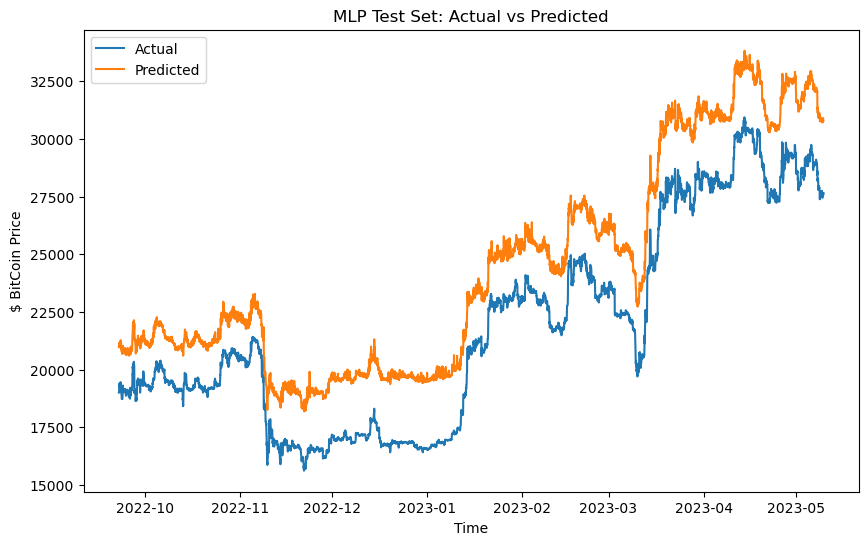

In [1140]:
plt.figure(figsize=(10,6))
plt.plot(y_test_d.index, y_test, label='Actual')
plt.plot(y_test_d.index, mlp_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('MLP Test Set: Actual vs Predicted')
plt.show()